In [75]:
import numpy as np
import pandas as pd
import time
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [414]:

file_path = 'FMR_All_1983_2026.csv'
df_fmr = pd.read_csv(file_path, encoding='windows-1252')

# Display the first few rows
print(df_fmr.columns)
print(df_fmr.head())

Index(['fips', 'fips2024', 'census_region', 'state', 'county', 'cousub',
       'areaname26', 'name', 'msa26', 'fmr26_0',
       ...
       'fmr85_3', 'fmr85_4', 'fmr85', 'msa83', 'fmr83_0', 'fmr83_1', 'fmr83_2',
       'fmr83_3', 'fmr83_4', 'fmr83'],
      dtype='object', length=310)
        fips   fips2024  census_region  state  county  cousub  \
0  100199999  100199999            3.0      1       1   99999   
1  100399999  100399999            3.0      1       3   99999   
2  100599999  100599999            3.0      1       5   99999   
3  100799999  100799999            3.0      1       7   99999   
4  100999999  100999999            3.0      1       9   99999   

                                 areaname26            name             msa26  \
0                        Montgomery, AL MSA  Autauga County  METRO33860M33860   
1             Daphne-Fairhope-Foley, AL MSA  Baldwin County  METRO19300M19300   
2                        Barbour County, AL  Barbour County  NCNTY01005N01005   

In [415]:
# Clean the data (remove dollar signs if needed)
for col in df_fmr.columns:
    if df_fmr[col].dtype == 'object' and df_fmr[col].str.contains(r'\$', na=False).any():
        df_fmr[col] = df_fmr[col].replace(r'[\$,]', '', regex=True).astype(float)
# Remove leading/trailing spaces from string columns
df_fmr = df_fmr.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

# drop rows with null values
df_fmr = df_fmr.dropna()
df_fmr.isnull().sum()

print(df_fmr.head())


        fips   fips2024  census_region  state  county  cousub  \
0  100199999  100199999            3.0      1       1   99999   
1  100399999  100399999            3.0      1       3   99999   
2  100599999  100599999            3.0      1       5   99999   
3  100799999  100799999            3.0      1       7   99999   
4  100999999  100999999            3.0      1       9   99999   

                                 areaname26            name             msa26  \
0                        Montgomery, AL MSA  Autauga County  METRO33860M33860   
1             Daphne-Fairhope-Foley, AL MSA  Baldwin County  METRO19300M19300   
2                        Barbour County, AL  Barbour County  NCNTY01005N01005   
3  Birmingham-Hoover, AL HUD Metro FMR Area     Bibb County  METRO13820M13820   
4  Birmingham-Hoover, AL HUD Metro FMR Area   Blount County  METRO13820M13820   

   fmr26_0  ...  fmr85_3  fmr85_4  fmr85    msa83 fmr83_0  fmr83_1  fmr83_2  \
0    860.0  ...    344.0    382.0   45.0   

In [416]:
# Add this at the top of your notebook or in your simulation class
STATE_CODES = {
    'Alabama': 1,
    'Alaska': 2,
    'Arizona': 4,
    'Arkansas': 5,
    'California': 6,
    'Colorado': 8,
    'Connecticut': 9,
    'Delaware': 10,
    'Florida': 12,
    'Georgia': 13,
    'Hawaii': 15,
    'Idaho': 16,
    'Illinois': 17,
    'Indiana': 18,
    'Iowa': 19,
    'Kansas': 20,
    'Kentucky': 21,
    'Louisiana': 22,
    'Maine': 23,
    'Maryland': 24,
    'Massachusetts': 25,
    'Michigan': 26,
    'Minnesota': 27,
    'Mississippi': 28,
    'Missouri': 29,
    'Montana': 30,
    'Nebraska': 31,
    'Nevada': 32,
    'New Hampshire': 33,
    'New Jersey': 34,
    'New Mexico': 35,
    'New York': 36,
    'North Carolina': 37,
    'North Dakota': 38,
    'Ohio': 39,
    'Oklahoma': 40,
    'Oregon': 41,
    'Pennsylvania': 42,
    'Rhode Island': 44,
    'South Carolina': 45,
    'South Dakota': 46,
    'Tennessee': 47,
    'Texas': 48,
    'Utah': 49,
    'Vermont': 50,
    'Virginia': 51,
    'Washington': 53,
    'West Virginia': 54,
    'Wisconsin': 55,
    'Wyoming': 56
}

In [417]:
def get_state_mean_rents(state_name):
    # Get state code
    state_code = STATE_CODES.get(state_name)
    if state_code is None:
        raise ValueError(f"State '{state_name}' not found in STATE_CODES")
    
    # Filter data for this state
    state_data = df_fmr[df_fmr['state'] == state_code]
    
    if len(state_data) == 0:
        raise ValueError(f"No data found for state code {state_code}")
    
    # Calculate means for each bedroom size using 2026 data
    mean_rents = {
        "studio": state_data["fmr26_0"].mean(),
        "1br": state_data["fmr26_1"].mean(),
        "2br": state_data["fmr26_2"].mean(),
        "3br": state_data["fmr26_3"].mean(),
        "4br": state_data["fmr26_4"].mean(),
    }
    
    # Calculate average annual growth rate using year-over-year changes from 2016-2026
    # Use strings with proper zero-padding
    years = ["16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26"]
    
    growth_rates = {}
    
    for room_type in ["studio", "1br", "2br", "3br", "4br"]:
        col_idx = {"studio": 0, "1br": 1, "2br": 2, "3br": 3, "4br": 4}[room_type]
        
        # Collect year-over-year growth rates
        yearly_growth_rates = []
        
        for i in range(len(years) - 1):
            current_year = years[i + 1]
            previous_year = years[i]
            
            rent_current = state_data[f"fmr{current_year}_{col_idx}"].mean()
            rent_previous = state_data[f"fmr{previous_year}_{col_idx}"].mean()
            
            if rent_previous > 0 and rent_current > 0:
                # Calculate growth rate for this year
                year_growth = (rent_current - rent_previous) / rent_previous
                yearly_growth_rates.append(year_growth)
        
        # Average all the yearly growth rates
        if yearly_growth_rates:
            growth_rates[room_type] = sum(yearly_growth_rates) / len(yearly_growth_rates)
        else:
            growth_rates[room_type] = 0.03  # Default 3%
    
    return mean_rents, growth_rates

In [418]:
# Test for Pennsylvania
pa_rents, pa_growth = get_state_mean_rents("Pennsylvania")  # ← Unpack both values
print("Pennsylvania Average Rents:")
for room_type, rent in pa_rents.items():
    print(f"  {room_type}: ${rent:.2f}")
print("\nPennsylvania Growth Rates:")
for room_type, rate in pa_growth.items():
    print(f"  {room_type}: {rate:.2%}")

# Test for California
ca_rents, ca_growth = get_state_mean_rents("California")  # ← Unpack both values
print("\nCalifornia Average Rents:")
for room_type, rent in ca_rents.items():
    print(f"  {room_type}: ${rent:.2f}")
print("\nCalifornia Growth Rates:")
for room_type, rate in ca_growth.items():
    print(f"  {room_type}: {rate:.2%}")

# Test for Hawaii
hw_rents, hw_growth = get_state_mean_rents("Hawaii")  # ← Unpack both values
print("\nHawaii Average Rents:")
for room_type, rent in hw_rents.items():
    print(f"  {room_type}: ${rent:.2f}")
print("\nHawaii Growth Rates:")
for room_type, rate in hw_growth.items():
    print(f"  {room_type}: {rate:.2%}")

Pennsylvania Average Rents:
  studio: $900.42
  1br: $995.91
  2br: $1225.04
  3br: $1570.46
  4br: $1744.36

Pennsylvania Growth Rates:
  studio: 5.07%
  1br: 4.76%
  2br: 4.62%
  3br: 4.59%
  4br: 4.61%

California Average Rents:
  studio: $1513.48
  1br: $1647.41
  2br: $2053.19
  3br: $2752.38
  4br: $3164.71

California Growth Rates:
  studio: 6.63%
  1br: 6.04%
  2br: 5.71%
  3br: 5.24%
  4br: 5.11%

Hawaii Average Rents:
  studio: $1782.75
  1br: $1849.00
  2br: $2418.50
  3br: $3140.00
  4br: $3717.75

Hawaii Growth Rates:
  studio: 6.47%
  1br: 5.16%
  2br: 5.47%
  3br: 4.72%
  4br: 5.10%


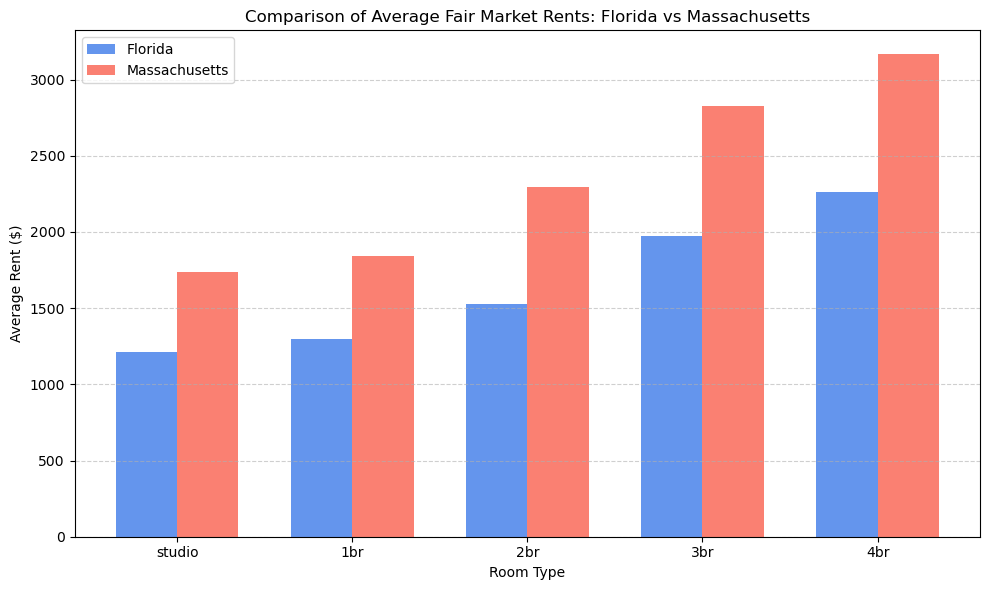

In [419]:
state1_name = "Florida"
state2_name = "Massachusetts"
state1_rents, _ = get_state_mean_rents(state1_name)
state2_rents, _ = get_state_mean_rents(state2_name)

# Extract room types and rent values
room_types = list(state1_rents.keys())
rents1 = [state1_rents[rt] for rt in room_types]
rents2 = [state2_rents[rt] for rt in room_types]

# Bar width and x locations
x = np.arange(len(room_types))
width = 0.35

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rents1, width, label=state1_name, color='cornflowerblue')
plt.bar(x + width/2, rents2, width, label=state2_name, color='salmon')

plt.xlabel("Room Type")
plt.ylabel("Average Rent ($)")
plt.title(f"Comparison of Average Fair Market Rents: {state1_name} vs {state2_name}")
plt.xticks(x, room_types)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [420]:
file_path = 'rental_vacancy_rate.csv'
df_rvr = pd.read_csv(file_path)

# Convert date column to datetime
df_rvr['observation_date'] = pd.to_datetime(df_rvr['observation_date'])

# Rename the column for clarity
df_rvr.rename(columns={"RRVRUSQ156N": "Vacancy Rate"}, inplace=True)

# Display the rows
# this dataset displays the rental vacancy rate in the US in the last ten years (divided by quarters) 
df_rvr.head()

,observation_date,Vacancy Rate
0,2015-04-01,6.8
1,2015-07-01,7.3
2,2015-10-01,7.0
3,2016-01-01,7.0
4,2016-04-01,6.7


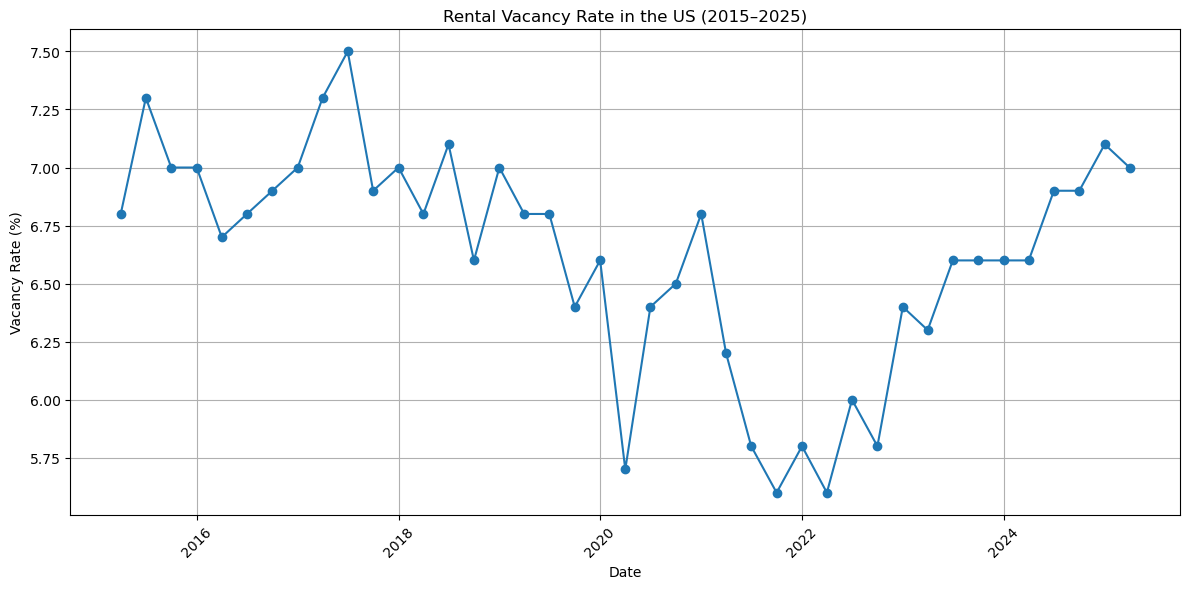

In [421]:
plt.figure(figsize=(12, 6))
plt.plot(df_rvr['observation_date'], df_rvr['Vacancy Rate'], marker='o')
plt.title("Rental Vacancy Rate in the US (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Vacancy Rate (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [422]:
file_path = 'Median Sales Price of Houses Sold.csv'
df_houseprice = pd.read_csv(file_path)

df_houseprice['observation_date'] = pd.to_datetime(df_houseprice['observation_date'])

df_houseprice.rename(columns={"MSPUS": "Median House Price"}, inplace=True)
df_houseprice

,observation_date,Median House Price
0,1963-01-01,17800
1,1963-04-01,18000
2,1963-07-01,17900
3,1963-10-01,18500
4,1964-01-01,18500
...,...,...
245,2024-04-01,414500
246,2024-07-01,415300
247,2024-10-01,419300
248,2025-01-01,423100


In [423]:
def get_house_price_growth(df_houseprice, start_year=2010, end_year=2025, default_growth=0.03):
    # Ensure sorted by date
    df_houseprice = df_houseprice.sort_values('observation_date').copy()
    
    # Filter to the desired years
    df_houseprice['year'] = df_houseprice['observation_date'].dt.year
    df_filtered = df_houseprice[(df_houseprice['year'] >= start_year) & (df_houseprice['year'] <= end_year)]
    
    if df_filtered.empty:
        return default_growth  # Fallback if no data
    
    # Group by year and take mean price (since quarterly, this averages Q1-Q4)
    annual_prices = df_filtered.groupby('year')['Median House Price'].mean()
    
    # Compute year-over-year % changes
    growth_rates = annual_prices.pct_change().dropna()  # Drops first NaN
    
    if growth_rates.empty:
        return default_growth
    
    # Average the growth rates
    avg_growth = growth_rates.mean()
    
    return avg_growth

house_growth_rate = get_house_price_growth(df_houseprice)
print(f"Average annual house price growth rate (2016-2025): {house_growth_rate:.4f} or {house_growth_rate * 100:.2f}%")

Average annual house price growth rate (2016-2025): 0.0441 or 4.41%


In [424]:
file_path = 'Real Median Household Income.csv'
df_income = pd.read_csv(file_path)

# Convert date column to datetime
df_income['observation_date'] = pd.to_datetime(df_income['observation_date'])

df_income.rename(columns={"MEHOINUSA672N": "Median Income"}, inplace=True)

In [425]:
df_income['year'] = df_income['observation_date'].dt.year
median_by_year = (
    df_income
    .groupby('year')['Median Income']
    .last()       # or .mean(), but .last() is common for annual series
    .to_dict()
)
# Pick a recent window, e.g. last 5 years available
all_years = sorted(median_by_year.keys())
window_years = all_years[-5:]           # last 5 years
baseline_year = window_years[0]         # first year in the window
baseline_median = median_by_year[baseline_year]

#  Compute growth factors relative to the baseline year
#    e.g. factor[baseline_year] = 1.0, later years >1 if incomes grew
income_growth_factor = {
    year: median_by_year[year] / baseline_median
    for year in window_years
}

In [426]:
# Add this function BEFORE the HousingSimulation class
def get_national_vacancy_rate():
    try:
        # Calculate average vacancy rate across all years
        avg_vacancy_rate = df_rvr['Vacancy Rate'].mean() / 100  # Convert percentage to decimal
        
        print(f"National Average Vacancy Rate (2015-2025): {avg_vacancy_rate:.2%}")
        
        return avg_vacancy_rate
    except Exception as e:
        print(f"Warning: Could not calculate vacancy rate from data: {e}")
        print("Using default national average: 6.5%")
        return 0.065  # Default national average

get_national_vacancy_rate()

National Average Vacancy Rate (2015-2025): 6.62%


0.06621951219512195

In [427]:
df_inventory = pd.read_csv("HousingInventory_RenterUnits.csv")
df_inventory['observation_date'] = pd.to_datetime(df_inventory['observation_date'])

# Rename the main column to something nicer
df_inventory.rename(columns={"ERNTOCCUSQ176N": "RenterUnits"}, inplace=True)

df_inventory.head()


,observation_date,RenterUnits
0,2000-04-01,33522
1,2000-07-01,33201
2,2000-10-01,33635
3,2001-01-01,33552
4,2001-04-01,33430


In [428]:
def get_rental_supply_growth(df_inventory, start_year=2010, end_year=2025, default_growth=0.01):

    df = df_inventory.sort_values('observation_date').copy()
    df['year'] = df['observation_date'].dt.year

    # Filter to window
    df_filtered = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    if df_filtered.empty:
        return default_growth

    # Annual average number of renter units
    annual_units = df_filtered.groupby('year')['RenterUnits'].mean()

    # Year-over-year % changes
    supply_growth_rates = annual_units.pct_change().dropna()
    if supply_growth_rates.empty:
        return default_growth

    return supply_growth_rates.mean()


In [429]:
supply_growth_rate = get_rental_supply_growth(df_inventory, start_year=2010, end_year=2024)
print(f"Average annual rental supply growth: {supply_growth_rate:.4f} or {supply_growth_rate*100:.2f}%")

Average annual rental supply growth: 0.0138 or 1.38%


In [430]:
class HousingUnit:
    def __init__(self, id, neighborhood: 'Neighborhood', rent, room_type):
        self.room_type = room_type
        self.id = id
        self.neighborhood = neighborhood
        self.rent = rent
        self.vacant = True
        self.tenant = None

In [431]:
HIGH_INCOME_THRESHOLD = 70000  # Threshold to categorize high vs low income
AFFORDABILITY_RATIO = 0.30  # Max 30% of income on rent_


class Household:
    def __init__(self, id, income, amenity_pref, move_tolerance, stability, cost_sensitivity):
        self.id = id
        self.income_base = income           # income at baseline_year
        self.income = income
        self.budget = AFFORDABILITY_RATIO * self.income / 12
        self.amenity_pref = amenity_pref # weight for neighborhood amenity in utility 
        self.move_tolerance = move_tolerance
        self.stability = stability           # probability of considering a move
        self.current_unit = None             # reference to current housing unit or location
        self.time_since_move = 0 
        self.cost_sensitivity = cost_sensitivity  # weight for rent cost in utility
        self.current_unit = None
        
    def move_to(self, unit: HousingUnit):    #Move to a new unit
        unit.vacant = False
        unit.tenant = self
        self.current_unit = unit
        
    def decide_and_move(self, available_units: list[HousingUnit]):
    
        # Stability / cooldown: most of the time they don't even consider moving
        if random.random() > (1 - self.stability) or self.time_since_move < 1:
            self.time_since_move += 1   # stability condition not met or still in cooldown
            return
    
        # Case 1: household currently has no unit (e.g., couldn't afford anything earlier)
        if self.current_unit is None:
            # Define housing_options from the available units (vacant only)
            housing_options = [u for u in available_units if u.vacant]
    
            # Affordable vacant units using the same budget variable you use below
            affordable = [u for u in housing_options if u.rent <= self.budget]
    
            if affordable:
                best = max(
                    affordable,
                    key=lambda u: self.calculate_utility(u.neighborhood.amenity, u.rent),
                )
                # Use the same move helper you use elsewhere (you had hh.move_to(unit) in init)
                self.move_to(best)
            return
    
        # Case 2: already housed → consider moving only if utility improves enough
    
        # Calculate current utility with normalized values
        curr_amenity = self.current_unit.neighborhood.amenity
        curr_rent = self.current_unit.rent
        current_utility = self.calculate_utility(curr_amenity, curr_rent)
    
        best_unit = None
        best_utility = current_utility
    
        for unit in available_units:
            if unit is self.current_unit or not unit.vacant:
                continue
            if unit.rent > self.budget:
                continue
    
            new_utility = self.calculate_utility(unit.neighborhood.amenity, unit.rent)
    
            # Only move if significantly better (moving cost ≈ 0.2 utility points)
            if new_utility - 0.2 > best_utility:
                best_utility = new_utility
                best_unit = unit
    
        if best_unit is not None:
            # Leave old unit
            self.current_unit.vacant = True
            self.current_unit.tenant = None
    
            # Move into the better unit
            self.move_to(best_unit)
            self.time_since_move = 0
        else:
            self.time_since_move += 1

            
    def calculate_utility(self, amenity, rent): #Calculate utility with normalized amenity and rent
        normalized_amenity = amenity / 10  # assuming 0-10 scale
        normalized_rent = rent / self.budget  # rent as fraction of budget
        utility = self.amenity_pref * normalized_amenity - self.cost_sensitivity * normalized_rent
        return utility


In [432]:
class Landlord:
    def __init__(self, id, unit: HousingUnit):
        self.id = id
        self.unit = unit
        self.unit.landlord = self
        self.vacancy_count = 0
        self.occupied_count = 0
        self.base_rent = unit.rent  #remember initial rent
        self.price_aggressiveness = random.uniform(0.5, 1.5)  #how reactive to the market
        
    def adjust_rent(self, demand_level, neighborhood_avg_rent, market_growth_rate, market_vacancy_rate):

        # Calculate current neighborhood vacancy rate
        neighborhood_units = self.unit.neighborhood.units
        neighborhood_vacancy = sum(1 for u in neighborhood_units if u.vacant) / len(neighborhood_units)
        
        if self.unit.vacant:
            self.vacancy_count += 1
            self.occupied_count = 0
        
        # Respond to vacancy based on market conditions
            if self.vacancy_count >= 6:  # After 6 months vacant
                # Compare neighborhood vacancy to market average
                if neighborhood_vacancy > market_vacancy_rate * 1.1:  # 10% worse than market
                    # Tight market - reduce aggressively
                    reduction = 0.1 * self.price_aggressiveness  # 4-12% reduction
                elif neighborhood_vacancy > market_vacancy_rate:
                    # Slightly worse than market
                    reduction = 0.05 * self.price_aggressiveness  # 2.5-7.5% reduction
                else:
                    # Neighborhood doing better than market
                    reduction = 0.02 * self.price_aggressiveness  # 1.5-4.5% reduction
                self.unit.rent *= (1 - reduction)
                self.unit.rent = max(self.unit.rent, self.base_rent * 0.70)  # Floor at 70% of base
        else:
            self.occupied_count += 1
            self.vacancy_count = 0
            # Apply market growth rate annually (every 12 months)
            if self.occupied_count >= 12:
                self.unit.rent *= (1 + market_growth_rate)
                self.occupied_count = 0  # Reset counter for next year
                # Additional increases in tight markets (low vacancy)
            elif self.occupied_count >= 6:  # After 6 months of occupancy
                if neighborhood_vacancy < market_vacancy_rate * 0.8:  # 20% better than market
                    # Tight market - can increase rent more aggressively
                    if demand_level == "high":
                        # High demand + low vacancy = strong market
                        extra_increase = 0.01 * self.price_aggressiveness  # ~0.5–1.5% extra per year
                        self.unit.rent *= (1 + extra_increase)
                        self.occupied_count = 0  # Reset after increase
            # Catch up to neighborhood average if below market
            if self.unit.rent < neighborhood_avg_rent * 0.80 and demand_level == "high":
                catchup = 0.05 * self.price_aggressiveness  # ~0.25–0.75% catch-up
                self.unit.rent *= (1 + catchup)
        # Cap rent growth at 200% of base rent
        self.unit.rent = min(self.unit.rent, self.base_rent * 2.0)

In [433]:
class Neighborhood:
    def __init__(self, name, initial_amenity):
        self.name = name
        self.amenity = initial_amenity
        self.units: List[HousingUnit] = []
        self.high_income_count = 0
        self.low_income_count = 0
        self.avg_rent = 0  # Track average rent in neighborhood

    
    def update_composition(self):       #Count resident income levels and calculate average rent
        self.high_income_count = 0
        self.low_income_count = 0
        total_rent = 0
        count = 0
        
        for unit in self.units:
            if not unit.vacant and unit.tenant:
                if unit.tenant.income > HIGH_INCOME_THRESHOLD:
                    self.high_income_count += 1
                else:
                    self.low_income_count += 1
                total_rent += unit.rent
                count += 1
        
        self.avg_rent = total_rent / count if count > 0 else 0

    
    def update_amenity(self):     #Adjust amenity based on residents
        total = self.high_income_count + self.low_income_count
        if total == 0:
            return
        
        high_proportion = self.high_income_count / total
        
        # More high-income residents → better amenities
        if high_proportion > 0.6:
            self.amenity += 0.1
        # Mostly low-income → amenity decays
        elif high_proportion < 0.3:
            self.amenity -= 0.05
        
        # Keep amenity in valid range
        self.amenity = max(0, min(self.amenity, 10))

In [445]:
class HousingSimulation:
    def __init__(self, n_households: int = 100, n_neighborhoods: int = 3,
                 units_per_neighborhood: int = 40, n_steps: int = 50,rent_growth_weight=0.5, state_name = None):
        self.n_households = n_households
        self.n_neighborhoods = n_neighborhoods
        self.units_per_neighborhood = units_per_neighborhood
        self.n_steps = n_steps

        self.baseline_year = baseline_year
        self.baseline_median_income = baseline_median
        self.income_growth_factor = income_growth_factor
        
        self.households: List[Household] = []
        self.landlords: List[Landlord] = []
        self.neighborhoods: List[Neighborhood] = []
        self.units: List[HousingUnit] = []

        self.avg_rent_history = []
        self.amenity_history = {i: [] for i in range(n_neighborhoods)}
        self.segregation_history = []

        self.rent_growth_weight = rent_growth_weight
        self.state_name = state_name
        self.mean_rents = None
        self.growth_rates = None
        self.blended_annual_growth = 0.0

        self.supply_growth_rate = 0.0

        self._initialize()

    
    def _initialize(self):
        # Choose state
        self.state_name = random.choice(list(STATE_CODES.keys()))
        
        # Get state-specific rent data
        self.mean_rents, self.growth_rates= get_state_mean_rents(self.state_name)
        self.avg_vacancy_rate = get_national_vacancy_rate()
        
        # Calculate house price growth (national)
        self.house_price_growth = get_house_price_growth(df_houseprice,start_year=2016, end_year=2025)

        # Blend the two growth rates
        fmr_growth = np.mean(list(self.growth_rates.values()))
        self.blended_annual_growth = (
            self.rent_growth_weight * fmr_growth
            + (1 - self.rent_growth_weight) * self.house_price_growth
        )


        self.supply_growth_rate = get_rental_supply_growth(
        df_inventory,
        start_year=2010,
        end_year=2024
        )
        
        print(f"Selected State: {self.state_name}")
        print(f"Average Rents: { {k: f'${v:,.0f}' for k,v in self.mean_rents.items()} }")
        print(f"FMR Growth Rate: {fmr_growth:.1%}/year")
        print(f"House Price Growth: {self.house_price_growth:.1%}/year")
        print(f"Effective Annual Rent Growth: {self.blended_annual_growth:.1%}/year")
        print(f"National Vacancy Rate: {self.avg_vacancy_rate:.1%}")
        print(f"Rental Supply Growth: {self.supply_growth_rate:.1%}/year")
        
        # Create neighborhoods
        for i in range(self.n_neighborhoods):
            amenity = random.uniform(4, 7)
            nbhd = Neighborhood(f"Area_{i+1}", amenity)
            self.neighborhoods.append(nbhd)
        
        # Create units and landlords
        room_types = ["studio", "1br", "2br", "3br", "4br"]
        
        unit_id = 0
        for nbhd in self.neighborhoods:
            for _ in range(self.units_per_neighborhood):
                room_type = random.choice(room_types)
                base_rent = self.mean_rents.get(room_type, 1000)
                rent = random.gauss(base_rent, base_rent * 0.1)
                rent = max(500, round(rent))

                print(f"Unit {unit_id}: Room Type = {room_type}, Rent = ${rent}")
                unit = HousingUnit(unit_id, nbhd, rent, room_type)
                nbhd.units.append(unit)
                self.units.append(unit)
                
                landlord = Landlord(unit_id, unit)
                self.landlords.append(landlord)
                unit_id += 1
        
        # Create households
        for i in range(self.n_households):
            mu = baseline_median                    # center of the distribution
            sigma = 0.4 * mu                        # spread = 40% of median (tune this)
            income = random.gauss(mu, sigma)
            # Clip to a reasonable range, e.g. 0.5x to 3x of baseline median
            income = max(0.5 * mu, min(income, 3 * mu))
            hh = Household(
                i, 
                income,
                amenity_pref=random.uniform(1.0, 3.0),      
                cost_sensitivity=random.uniform(1.0, 2.5),  
                move_tolerance=random.uniform(0.2, 0.8),    
                stability=random.uniform(0.8, 0.95)         
            )
            self.households.append(hh)
        
        # Initial placement
        available = self.units.copy()
        random.shuffle(available)
        for hh in self.households:
            affordable = [u for u in available if u.rent <= hh.budget]
            if affordable:
                unit = affordable[0]
                hh.move_to(unit)
                available.remove(unit)
                
        self.total_units = sum(len(nbhd.units) for nbhd in self.neighborhoods)
        self.next_unit_id = self.total_units
        self.next_landlord_id = len(self.landlords)

    def get_income_factor_for_year(self, year: int) -> float:
        # If you haven't set income_growth_factor, just return 1.0
        if not hasattr(self, "income_growth_factor") or not self.income_growth_factor:
            return 1.0

        years = sorted(self.income_growth_factor.keys())

        # Before or at baseline → no growth
        if year <= self.baseline_year:
            return 1.0

        # After last data year → clamp to last factor
        if year >= years[-1]:
            return self.income_growth_factor[years[-1]]

        # Exact year available
        if year in self.income_growth_factor:
            return self.income_growth_factor[year]

        # (Optional) interpolate between nearest years
        smaller_years = [y for y in years if y < year]
        larger_years = [y for y in years if y > year]
        y1, y2 = max(smaller_years), min(larger_years)
        f1, f2 = self.income_growth_factor[y1], self.income_growth_factor[y2]
        alpha = (year - y1) / (y2 - y1)
        return f1 + alpha * (f2 - f1)

    
    def update_household_incomes(self, step: int):
        # Convert month step to year offset
        years_passed = step // 12
        current_year = self.baseline_year + years_passed

        factor = self.get_income_factor_for_year(current_year)

        for hh in self.households:
            hh.income = hh.income_base * factor
            hh.budget = AFFORDABILITY_RATIO * hh.income

    def add_new_units(self):
        if self.supply_growth_rate <= 0:
            return
    
        num_new_units = max(1, int(self.total_units * self.supply_growth_rate))
        room_types = ["studio", "1br", "2br", "3br", "4br"]
    
        for _ in range(num_new_units):
            # 1) pick a neighborhood
            nbhd = random.choice(self.neighborhoods)
    
            # 2) pick room type + rent around that type's mean
            room_type = random.choice(room_types)
            base_mean = self.mean_rents[room_type]
            rent = random.gauss(base_mean, 0.1 * base_mean)
            rent = max(500, round(rent))
    
            # 3) create HousingUnit 
            unit = HousingUnit(self.next_unit_id, nbhd, rent, room_type)
            nbhd.units.append(unit)
            self.units.append(unit)
    
            # 4) create Landlord 
            landlord = Landlord(self.next_landlord_id, unit)
            self.landlords.append(landlord)
    
            # 5) update counters
            self.next_unit_id += 1
            self.next_landlord_id += 1
            self.total_units += 1


    def run(self):
        for t in range(self.n_steps):
            
            if t > 0 and t % 12 == 0:
                print(f"Adding new units at step {t}...")
                self.add_new_units()
            
            self.update_household_incomes(t)
            
            # 1. Households consider moving
            for hh in self.households:
                hh.decide_and_move(self.units)
            
            # 2. Landlords adjust rents
            for landlord in self.landlords:
                nbhd = landlord.unit.neighborhood
                demand = "high" if nbhd.high_income_count > nbhd.low_income_count else "low"
                room_type = landlord.unit.room_type
                market_growth = self.blended_annual_growth
                landlord.adjust_rent(demand, nbhd.avg_rent, market_growth, self.avg_vacancy_rate)
            
            # 3. Neighborhoods update
            for nbhd in self.neighborhoods:
                nbhd.update_composition()
                nbhd.update_amenity()
            
            # 4. Collect data
            self._collect_data()

    
    def _collect_data(self):
        
        # Average rent
        occupied_rents = [l.unit.rent for l in self.landlords if not l.unit.vacant]
        avg_rent = np.mean(occupied_rents) if occupied_rents else 0
        self.avg_rent_history.append(avg_rent)
        
        # Amenity by neighborhood
        for i, nbhd in enumerate(self.neighborhoods):
            self.amenity_history[i].append(nbhd.amenity)
        
        # Segregation (variance of neighborhood average incomes)
        nbhd_incomes = []
        for nbhd in self.neighborhoods:
            incomes = [u.tenant.income for u in nbhd.units 
                      if not u.vacant and u.tenant]
            if incomes:
                nbhd_incomes.append(np.mean(incomes))
        
        if nbhd_incomes:
            segregation = np.var(nbhd_incomes)
        else:
            segregation = 0
        self.segregation_history.append(segregation)


    def visualize(self):
        
        # Plot 1: Rent trend
        plt.figure(figsize=(8,4))
        plt.plot(self.avg_rent_history, linewidth=2.2, color="steelblue")
        plt.title(f"Average Rent Over Time ({self.state_name})", fontsize=13)
        plt.xlabel("Time Step")
        plt.ylabel("Average Rent ($)")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        
        # Plot 2: Amenity evolution
        plt.figure(figsize=(8,4))
        for nbhd_id, series in self.amenity_history.items():
            plt.plot(series, linewidth=2, label=f"Area {nbhd_id+1}", alpha=0.8)
        plt.title(f"Neighborhood Amenity Scores ({self.state_name})", fontsize=13)
        plt.xlabel("Time Step")
        plt.ylabel("Amenity Score")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        rents = []
        incomes = []
        income_group = []
        
        # Plot 3: Collect data from all occupied units
        for nbhd in sim.neighborhoods:
            for unit in nbhd.units:
                if unit.tenant is not None:
                    rents.append(unit.rent)
                    incomes.append(unit.tenant.income)
                    if unit.tenant.income >= HIGH_INCOME_THRESHOLD:
                        income_group.append("High-income")
                    else:
                        income_group.append("Low-income")
        
        rents = np.array(rents)
        incomes = np.array(incomes)
        income_group = np.array(income_group)
        
        mask_high = income_group == "High-income"
        mask_low = ~mask_high
        
        plt.figure(figsize=(9, 6))
        
        # Low-income households
        plt.scatter(
            incomes[mask_low],
            rents[mask_low],
            alpha=0.5,
            label="Low-income households",
        )
        
        # High-income households
        plt.scatter(
            incomes[mask_high],
            rents[mask_high],
            alpha=0.7,
            marker="^",
            label="High-income households",
        )
        
        # 30% affordability line: rent = AFFORDABILITY_RATIO * income
        income_grid = np.linspace(incomes.min()*0.9, incomes.max()*1.05, 200)
        affordable_rent = AFFORDABILITY_RATIO * income_grid / 12
        plt.plot(
            income_grid,
            affordable_rent,
            linestyle="--",
            linewidth=1.5,
            label=f"{int(AFFORDABILITY_RATIO*100)}% of income (budget rule)",
        )
        
        plt.xlabel("Household income")
        plt.ylabel("Monthly rent")
        plt.title("Income vs rent for occupied units\n(final simulation step)")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.show()


        
        # Plot 4: Distribution of rent burden at final simulation step
        ratios = []   # rent as share of annual income
        groups = []   # "High-income" or "Low-income"
        
        for nbhd in sim.neighborhoods:
            for unit in nbhd.units:
                if unit.tenant is not None:               # only occupied units
                    income = unit.tenant.income           # annual income
                    rent = unit.rent                      # monthly rent
                    if income <= 0:
                        continue                         
        
                    # rent as share of annual income (equivalent to monthly rent / monthly income)
                    rent_share = (rent * 12) / income
                    ratios.append(rent_share)
        
                    groups.append(
                        "High-income" if income >= HIGH_INCOME_THRESHOLD else "Low-income"
                    )
        
        if ratios:
            ratios = np.array(ratios)
            groups = np.array(groups)
        
            # Histogram bins from 0 up to a bit above the max ratio (or at least 0.8)
            bins = np.linspace(0, max(0.8, ratios.max() * 1.05), 20)
        
            plt.figure(figsize=(8, 5))
        
            # Low-income households
            plt.hist(
                ratios[groups == "Low-income"],
                bins=bins,
                alpha=0.6,
                label="Low-income households",
            )
        
            # High-income households
            plt.hist(
                ratios[groups == "High-income"],
                bins=bins,
                alpha=0.6,
                label="High-income households",
            )
        
            # 30% affordability cutoff
            plt.axvline(
                AFFORDABILITY_RATIO,
                linestyle="--",
                linewidth=1.5,
                label=f"{int(AFFORDABILITY_RATIO * 100)}% affordability cutoff",
            )
        
            plt.xlabel("Rent as share of annual income")
            plt.ylabel("Number of households")
            plt.title("Distribution of rent burden by income group\n(final simulation step)")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
        
            # Print cost-burdened shares for your write-up
            overall_cost_burdened = np.mean(ratios > AFFORDABILITY_RATIO)
            low_cost_burdened = np.mean(ratios[groups == "Low-income"] > AFFORDABILITY_RATIO)
            high_cost_burdened = np.mean(ratios[groups == "High-income"] > AFFORDABILITY_RATIO)
        
            print(f"Overall share > {AFFORDABILITY_RATIO:.0%} of income: {overall_cost_burdened:.1%}")
            print(f"Low-income share  > {AFFORDABILITY_RATIO:.0%}: {low_cost_burdened:.1%}")
            print(f"High-income share > {AFFORDABILITY_RATIO:.0%}: {high_cost_burdened:.1%}")
        else:
            print("No occupied units at final step; cannot compute rent-burden distribution.")
        


National Average Vacancy Rate (2015-2025): 6.62%
Selected State: Oklahoma
Average Rents: {'studio': '$744', '1br': '$791', '2br': '$995', '3br': '$1,297', '4br': '$1,501'}
FMR Growth Rate: 3.9%/year
House Price Growth: 3.7%/year
Effective Annual Rent Growth: 3.8%/year
National Vacancy Rate: 6.6%
Rental Supply Growth: 1.4%/year
Unit 0: Room Type = 3br, Rent = $1241
Unit 1: Room Type = 4br, Rent = $1475
Unit 2: Room Type = 2br, Rent = $936
Unit 3: Room Type = 4br, Rent = $1231
Unit 4: Room Type = 1br, Rent = $718
Unit 5: Room Type = 3br, Rent = $1295
Unit 6: Room Type = 4br, Rent = $1324
Unit 7: Room Type = 2br, Rent = $1128
Unit 8: Room Type = 4br, Rent = $1374
Unit 9: Room Type = studio, Rent = $793
Unit 10: Room Type = 4br, Rent = $1484
Unit 11: Room Type = studio, Rent = $622
Unit 12: Room Type = 2br, Rent = $959
Unit 13: Room Type = 4br, Rent = $1593
Unit 14: Room Type = 1br, Rent = $908
Unit 15: Room Type = 3br, Rent = $1119
Unit 16: Room Type = 2br, Rent = $1277
Unit 17: Room Type

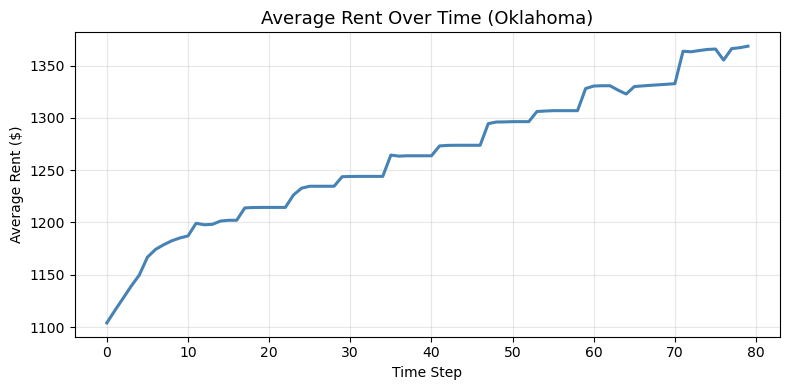

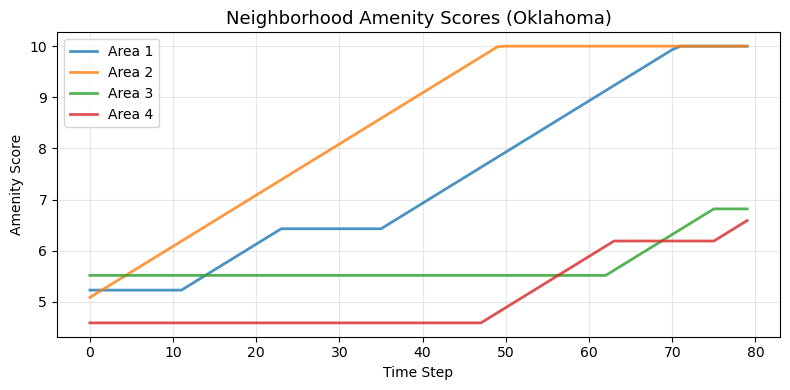

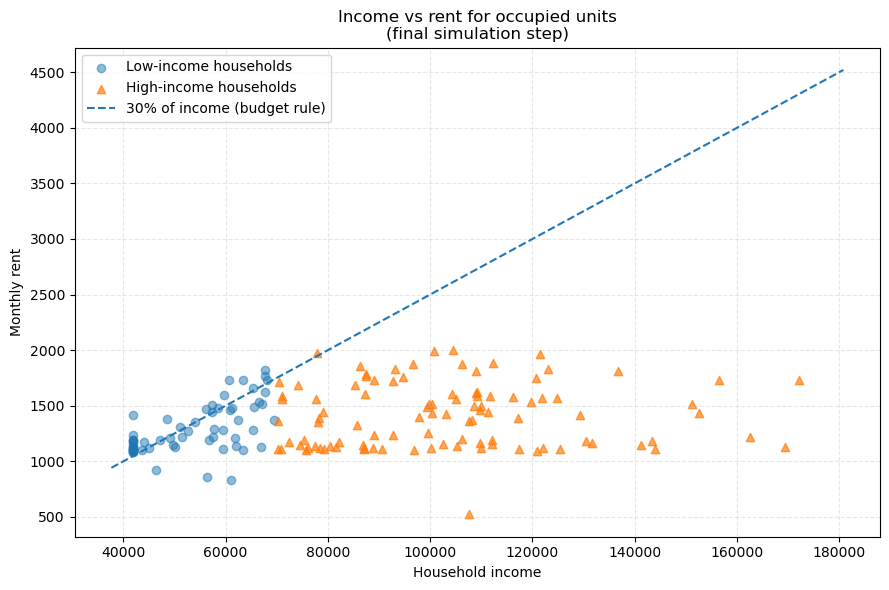

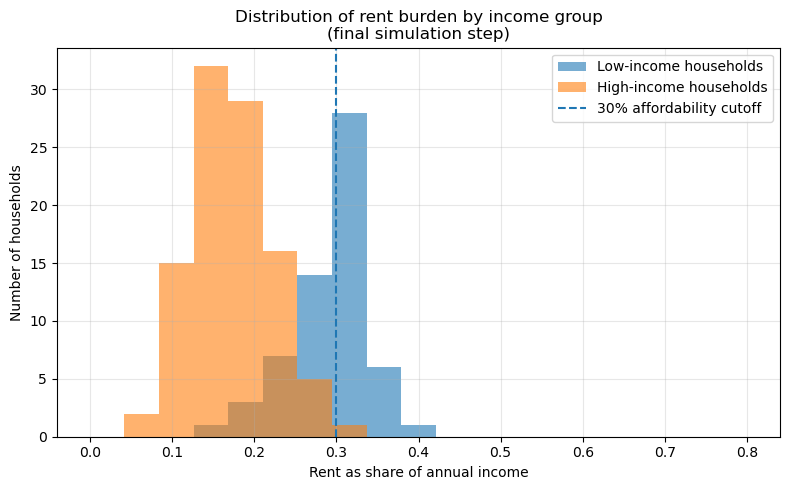

Overall share > 30% of income: 21.2%
Low-income share  > 30%: 55.0%
High-income share > 30%: 1.0%


In [450]:
# Without calibration


sim =HousingSimulation(
    n_households=160,
    n_neighborhoods=4,
    units_per_neighborhood=40,
    n_steps=80,
)
    
sim.run()
sim.visualize()